In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
from brmspy.brms import bf
from brmspy import brms

In [3]:
with brms.manage(environment_name="mrp") as ctx:
    ctx.install_brms(use_prebuilt=True)
    ctx.install_rpackage("MCMCglmm")

REMOTE CALL


[brmspy][install_brms] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[R]: Error in loadNamespace(x) : there is no package called ‘cmdstanr’
  
[brmspy][install_brms] lib paths are ['/Users/sebastian/.brmspy/environment/mrp/Rlib', '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][install_brms] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan


REMOTE CALL
REMOTE CALL
lib path is ['/Users/sebastian/.brmspy/environment/mrp/Rlib']


[brmspy][worker_main] MCMCglmm 2.36 already installed.


In [6]:
data = brms.get_brms_data("epilepsy")

REMOTE CALL


In [7]:
r1 = brms.brm(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    data=data,
    family="poisson",
    warmup=500,
    iter=1000,
    chains=4
)


REMOTE CALL


[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[R]: Compiling Stan program...
  


[R]: Start sampling
  


Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 9

In [8]:
r1

FitResult(r= Family: poisson 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.58      0.07     0.45     0.72 1.01      469      880

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.05      0.28     1.51     2.59 1.00      368      568
zAge          0.10      0.08    -0.06     0.26 1.00      411      743
zBase         0.65      0.25     0.15     1.13 1.01      307      545
Trt          -0.27      0.17    -0.61     0.06 1.00      398      697
zBase:Trt     0.06      0.16    -0.25     0.37 1.00      352      464

Draws were sampled using sample(hmc). For ea

In [9]:
brms.summary(r1)

REMOTE CALL


 Family: poisson 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.58      0.07     0.45     0.72 1.01      469      880

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.05      0.28     1.51     2.59 1.00      368      568
zAge          0.10      0.08    -0.06     0.26 1.00      411      743
zBase         0.65      0.25     0.15     1.13 1.01      307      545
Trt          -0.27      0.17    -0.61     0.06 1.00      398      697
zBase:Trt     0.06      0.16    -0.25     0.37 1.00      352      464

Draws were sampled using sample(hmc). For each parameter

In [10]:
import arviz as az

<Axes: xlabel='count'>

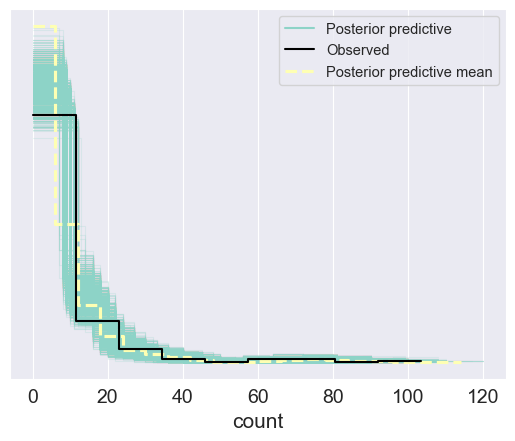

In [11]:
az.plot_ppc(r1.idata)